In [1]:
from causalimpact import CausalImpact

import numpy as np
import pandas as pd
import datetime
from datetime import datetime

from statsmodels.tsa.arima_process import ArmaProcess

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters

In [3]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
import warnings
warnings.filterwarnings("ignore")

# **Media Culture's Data for CPT**

In [5]:
koeppel_data = pd.read_csv("KOEPPEL FUNNEL.csv", parse_dates=['Date'])

In [6]:
#Transforming data
koeppel_data = koeppel_data.dropna(how='any', subset=['Date'], axis = 0)
koeppel_data['tCVR'] = koeppel_data['tCVR'].str.rstrip("%").astype(float)/100

koeppel_data['CPT'] = koeppel_data.CPT.str[1:].astype(str).astype(float)
koeppel_data['CPI'] = koeppel_data.CPI.str[1:].astype(str).astype(float)
koeppel_data['Spend'] = koeppel_data.Spend.str[1:].str.replace(',', '').astype(str).astype(float)
koeppel_data['Rate'] = koeppel_data.Rate.str[1:].astype(str).astype(float)

koeppel_data['Frequency'] = koeppel_data['Frequency'].astype(str).astype(int)

koeppel_data['Trials'] = koeppel_data['Trials'].astype(str).astype(int)

koeppel_data['Installs'] = koeppel_data['Installs'].str.replace(',', '').astype(str).astype(int)

In [7]:
koeppel_data=koeppel_data.sort_values(by=['Date'])
#reset indexes
koeppel_data.reset_index(drop=True, inplace = True)

In [8]:
print('Number of trials in the post-period when TV ads were on: ',koeppel_data.Trials.sum())

Number of trials in the post-period when TV ads were on:  17573


In [9]:
print('Total spend in the post-period when TV ads were on: ', koeppel_data.Spend.sum(), '$')

Total spend in the post-period when TV ads were on:  626070.0 $


In [10]:
print('Average CPT in the post-period when TV ads were on: : ', round(koeppel_data.Spend.sum() / koeppel_data.Trials.sum(),2),'$')

Average CPT in the post-period when TV ads were on: :  35.63 $


In [82]:
koeppel_data_trials = koeppel_data[['Date', 'Trials']]
koeppel_data_trials.set_index('Date', inplace=True)

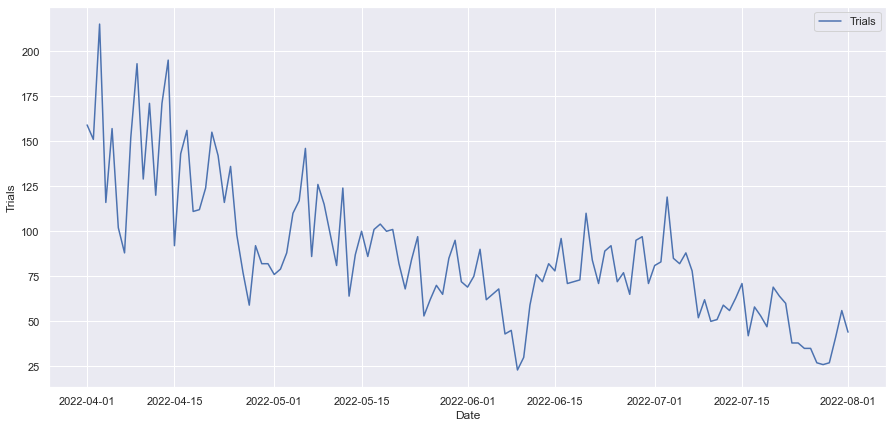

In [83]:
sns.set(rc={'figure.figsize':(15,7)})
sns.lineplot(x=koeppel_data_trials.loc[(koeppel_data_trials.index >= '2022-04-01') & (koeppel_data_trials.index <= '2022-08-01')].index, y=koeppel_data_trials.loc[(koeppel_data_trials.index >= '2022-04-01') & (koeppel_data_trials.index <= '2022-08-01'),'Trials'])
plt.legend(labels = ['Trials'])

# **Data - from Subscription Dashboard**

In [11]:
data = pd.read_csv("Subscribers Uplift US.csv", skiprows = 1, usecols=[0,2], names=['Date','Trials'], header=None, parse_dates=['Date'])

In [12]:
data.head(2)

,Date,Trials
0,2021-07-01,19
1,2021-07-02,69


In [13]:
data.shape

(477, 2)

In [14]:
data.Date.min()

Timestamp('2021-07-01 00:00:00')

In [15]:
data.Date.max()

Timestamp('2022-10-20 00:00:00')

In [16]:
print('Time period is: from ', data.Date.min().date(), ' to ', data.Date.max().date())

Time period is: from  2021-07-01  to  2022-10-20


Changing data types

In [17]:
data['Trials'] = data['Trials'].str.replace(',', '').astype(str).astype(int)

In [18]:
data.dtypes

Date      datetime64[ns]
Trials             int32
dtype: object

In [19]:
data=data.sort_values(by=['Date'])
#reset indexes
data.reset_index(drop=True, inplace = True)

In [20]:
# Set pre-period
pre_period = [str(data.Date.min())[:10], str('2022-03-13')]
# Set post-period
post_period = [str('2022-03-14'), str(data.Date.max())[:10]]

In [21]:
print('Pre-period is from ', pre_period[0], ' to ', pre_period[1])
print('Post-period is from ', post_period[0], ' to ', post_period[1])

Pre-period is from  2021-07-01  to  2022-03-13
Post-period is from  2022-03-14  to  2022-10-20


# **Causal Impact model**

In [22]:
model_data=data[['Date', 'Trials']]
model_data.set_index('Date', inplace=True)

In [23]:
print('Trials for the post period: ',model_data.loc[model_data.index >= '2022-03-14','Trials'].sum())

Trials for the post period:  43461


In [24]:
print('Trials for the pre period: ', model_data.loc[model_data.index < '2022-03-14','Trials'].sum())

Trials for the pre period:  44296


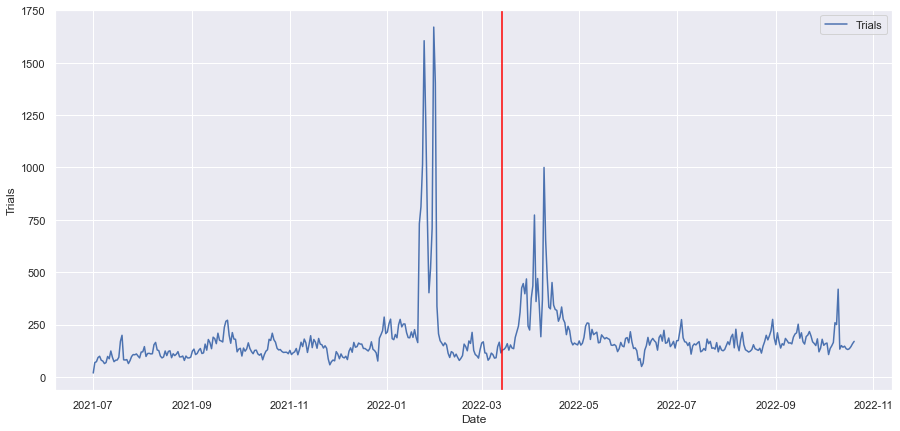

In [25]:
sns.set(rc={'figure.figsize':(15,7)})
sns.lineplot(x=data.Date, y=data['Trials'])
plt.axvline(x= data.Date.loc[data['Date'] == '2022-03-14'], color='red')
plt.legend(labels = ['Trials'])

Noise in the data - jump in time-series from 21/01 to 31/01

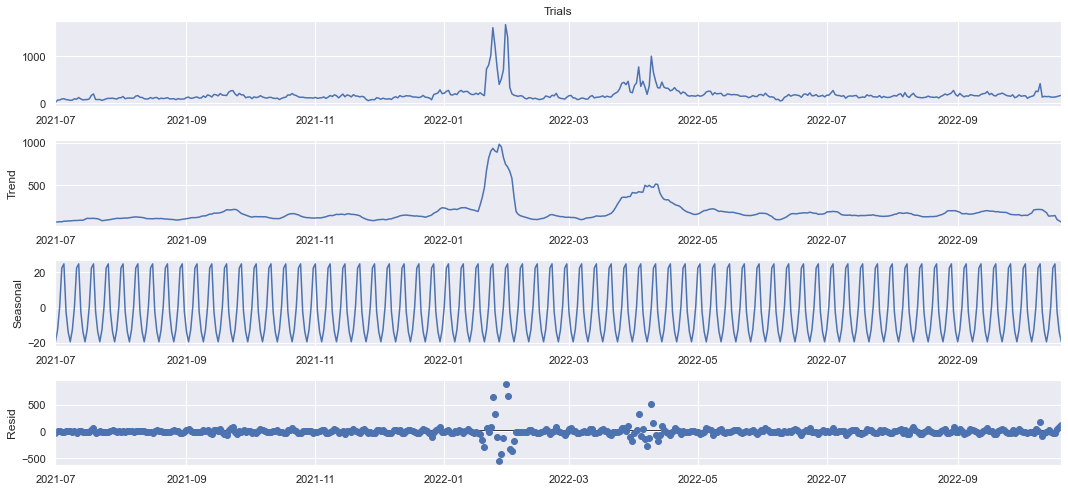

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(model_data['Trials'], model = 'additive', extrapolate_trend = 'freq')
result.plot()
plt.show()

Time series has weekly seasonality!

Trying to remove jump/noise in the data for period 21/01 to 31/01: - **replacing with average from period before and after**

In [27]:
model_data.loc[((model_data.index >= '2022-01-21') & (model_data.index <= '2022-02-01'))].mean()

Trials    932.5
dtype: float64

In [28]:
model_data.loc[((model_data.index >= '2021-12-21') & (model_data.index <= '2022-01-20')) |
              ((model_data.index >= '2022-02-02') & (model_data.index <= '2022-03-01'))].mean()[0]

167.71186440677965

In [29]:
model_data.loc[((model_data.index >= '2022-01-21') & (model_data.index <= '2022-02-01'))] = model_data.loc[((model_data.index >= '2021-12-21') & (model_data.index <= '2022-01-20')) |
              ((model_data.index >= '2022-02-02') & (model_data.index <= '2022-03-01'))].mean()[0]

In [30]:
model_data.loc[((model_data.index >= '2022-01-21') & (model_data.index <= '2022-02-01'))]

,Trials
Date,
2022-01-21,167.711864
2022-01-22,167.711864
2022-01-23,167.711864
2022-01-24,167.711864
2022-01-25,167.711864
2022-01-26,167.711864
2022-01-27,167.711864
2022-01-28,167.711864
2022-01-29,167.711864


Data after:

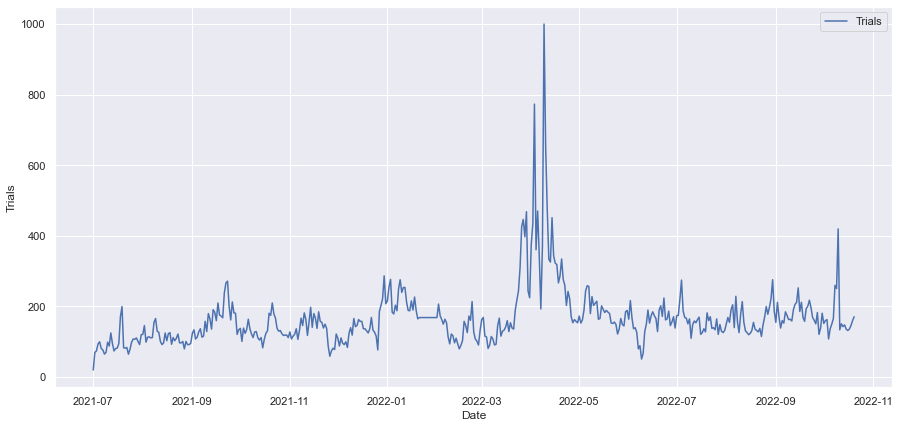

In [31]:
sns.set(rc={'figure.figsize':(15,7)})
sns.lineplot(x=model_data.index, y=model_data['Trials'])
plt.legend(labels = ['Trials'])

**Causal Impact model:**

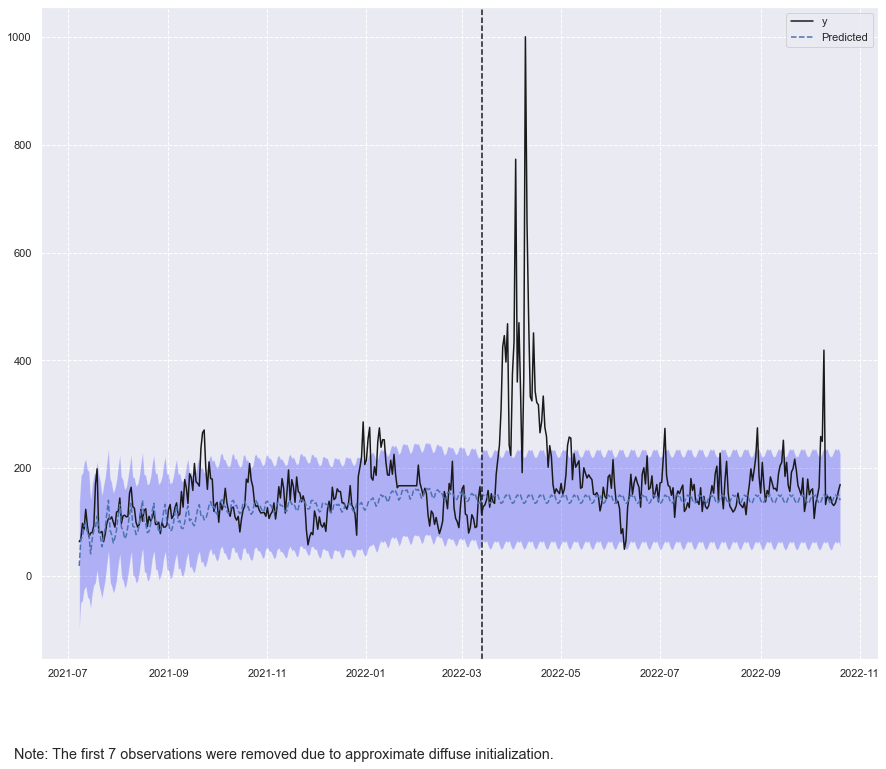

In [32]:
# Causal impact model, prior_level_sd default of 0.01
impact = CausalImpact(data=model_data.Trials, pre_period=pre_period, post_period=post_period, prior_level_sd =0.01,
                     nseasons=[{'period': 7}]
                     )
impact.plot(panels=['original'])

In [33]:
impact.inferences.preds.loc[impact.inferences.preds.index >= '2022-03-14']

Date
2022-03-14    150.648960
2022-03-15    147.587451
2022-03-16    150.645057
2022-03-17    140.851570
2022-03-18    135.000152
                 ...    
2022-10-16    145.177754
2022-10-17    150.648960
2022-10-18    147.587451
2022-10-19    150.645057
2022-10-20    140.851570
Freq: D, Name: preds, Length: 221, dtype: float64

# **Lift by months**

In [63]:
estimates_post = impact.inferences.preds.loc[impact.inferences.preds.index >= '2022-03-14'].groupby([lambda x: x.year, lambda x: x.month]).sum()

In [64]:
real_trials = model_data[model_data.index >= '2022-03-14'].groupby([lambda x: x.year, lambda x: x.month]).sum()

In [65]:
lift_by_months = pd.merge(estimates_post, real_trials , left_index = True, right_index = True)

In [66]:
spend = koeppel_data[['Date', 'Spend']].set_index('Date').groupby([lambda x: x.year, lambda x: x.month]).Spend.sum()

In [67]:
lift_by_months = lift_by_months.merge(spend, left_index = True, right_index = True)

In [68]:
koeppel_trials = koeppel_data[['Date','Trials']].set_index('Date').groupby([lambda x: x.year, lambda x: x.month]).Trials.sum()

In [69]:
lift_by_months = lift_by_months.merge(koeppel_trials, left_index = True, right_index = True)

In [70]:
lift_by_months.rename(columns = {'Trials_x':'Trials', 'Trials_y':'Trials_koeppel'}, inplace = True)

In [71]:
lift_by_months['CPT'] = round(lift_by_months.Spend / lift_by_months.Trials_koeppel)

In [72]:
lift_by_months['lift'] = round((lift_by_months.Trials - lift_by_months.preds) / lift_by_months.Trials * 100,2)

In [85]:
lift_by_months[['lift']]

lift
Date Date       
2022 3     39.11
     4     58.75
     5     20.22
     6      5.57
     7      7.77
     8     11.43
     9     18.91
     10    15.23

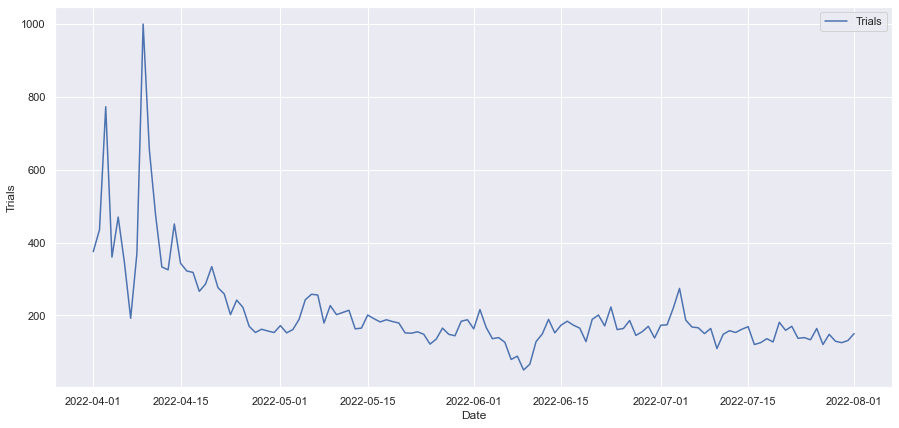

In [81]:
sns.set(rc={'figure.figsize':(15,7)})
sns.lineplot(x=model_data.loc[(model_data.index >= '2022-04-01') & (model_data.index <= '2022-08-01')].index, y=model_data.loc[(model_data.index >= '2022-04-01') & (model_data.index <= '2022-08-01'),'Trials'])
plt.legend(labels = ['Trials'])

Model results summary:

In [75]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 196.66. By contrast, in the absence of an
intervention, we would have expected an average response of 143.91.
The 95% interval of this counterfactual prediction is [128.85, 158.51].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 52.75 with a 95% interval of
[38.15, 67.8]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 43461.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 31803.8. The 95% interval of this prediction is [28476.19, 35029.88].


The above results are given in terms of absolute numbers. In relative
terms, the respon

In [207]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#print('MAE: ', mean_absolute_error( model_data.loc[model_data.index < '2022-03-14','Trials'], impact.inferences.preds.loc[impact.inferences.preds.index < '2022-03-14']))
#print('MAPE: ',mean_absolute_percentage_error( model_data.loc[model_data.index < '2022-03-14','Trials'], impact.inferences.preds.loc[impact.inferences.preds.index < '2022-03-14']))
#print('RMSE: ', mean_squared_error(model_data.loc[model_data.index < '2022-03-14','Trials'], impact.inferences.preds.loc[impact.inferences.preds.index < '2022-03-14'], squared=False))

**Lift: ( 43461.0 - 31803.8) / 43461.0 = 26.8%**

# **ARIMA**

In [78]:
result = adfuller(model_data['Trials'])
print('ADF Statistic: {}'.format(result[0]))
print('P-Values: {}'.format(result[1]))

print('Critical Values: ')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.509658076104156
P-Values: 0.007742491124293684
Critical Values: 
	1%: -3.4444914328761977
	5%: -2.8677756786103683
	10%: -2.570091378194011


Stationary!

In [79]:
from pmdarima.arima.utils import ndiffs

ndiffs(model_data['Trials'], test='adf')  #1

1

In [80]:
ndiffs(model_data['Trials'], test='kpss')  #1

1

**d = 1**

In [ ]:
plot_pacf(model_data['Trials'].dropna())
plt.show()
# max 2

In [ ]:
plot_acf(model_data['Trials'].dropna()) 
# max 6

In [101]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(model_data, start_p=1, start_q=1,
                      test='adf',
                      max_p=2, max_q=6,
                      m=1,             
                      d=1,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=5218.094, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=5168.555, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=5135.516, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=5134.900, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=5136.872, Time=0.25 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=5131.242, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=5194.828, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=5135.973, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=5135.584, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=5136.895, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=5134.784, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=5178.288, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=5134.257, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=5126.810, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=5118.449, Time=0.42 sec

Best mode

In [84]:
#ARIMA(2,1,3)

In [208]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(model_data['Trials'],order =(2,1,3), seasonal_order = (1,0,1,7))
results = model_sarima.fit()

#results.summary()

In [209]:
forecats_sarimax= results.predict(start=model_data.index.min(),end=model_data.index.max())

Predicted Price pct change


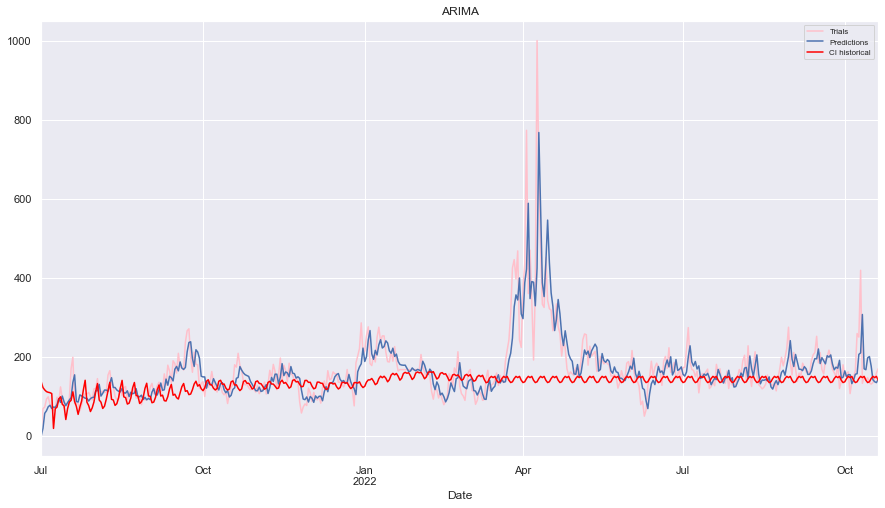

In [210]:
print("Predicted Price pct change")
def plotARMA(df_accumulative,ax, model):
    result=df_accumulative
    mod = model
    res = mod.fit()
    # Plot the original series and the forecasted series
    #res.plot_predict(start=0, end=400)
    df_accumulative.plot(ax=ax,label='Trials', color = 'pink')
    res.predict().plot(ax=ax,label='Predictions')
    plt.plot(impact.inferences.preds, color = 'red', label = 'CI historical')

fig,ax = plt.subplots(figsize=(15,8))    
plotARMA(model_data['Trials'],ax, model_sarima)
plt.legend(fontsize=8)
plt.title("ARIMA")
plt.show()

# **ARIMA predictions based on CI estimations for future month period**

<AxesSubplot:xlabel='Date'>

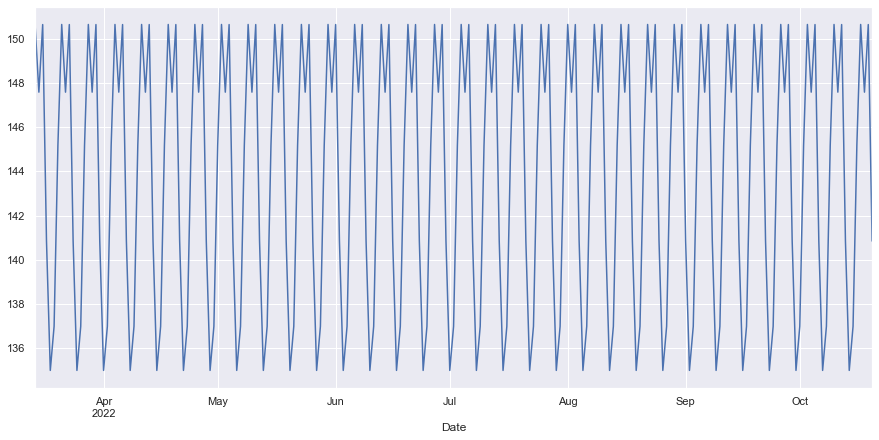

In [211]:
impact.inferences.preds.loc[impact.inferences.preds.index >= '2022-03-14'].plot()

In [212]:
ci_post = impact.inferences.preds.loc[impact.inferences.preds.index >= '2022-03-14']

In [213]:
ci_post.shape

(221,)

In [214]:
result = adfuller(ci_post)
print('ADF Statistic: {}'.format(result[0]))
print('P-Values: {}'.format(result[1]))

print('Critical Values: ')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -27888327149672.23
P-Values: 0.0
Critical Values: 
	1%: -3.4612821203214907
	5%: -2.875142613826617
	10%: -2.574020122281422


Time-series is stationary!

In [215]:
from pmdarima.arima.utils import ndiffs

print(ndiffs(ci_post, test='adf'))  
print(ndiffs(ci_post, test='kpss')  )

0
0


**d = 0**

In [ ]:
plot_pacf(ci_post)
plt.show()

In [ ]:
plot_acf(ci_post) 

In [180]:
from pmdarima.arima import auto_arima

auto_model = auto_arima(ci_post, start_p=1, start_q=1,
                      test='adf',
                      max_p=4, max_q=4,
                      m=1,             
                      d=0,          
                      seasonal=True,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1413.889, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1357.367, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1321.708, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1256.796, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=1232.605, Time=0.32 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1179.583, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=1089.693, Tim

In [181]:
#ARIMA(4,0,1)

November and December for future months:

In [182]:
from datetime import date, timedelta

sdate = date(2022,10,21) 
edate = date(2023,1,1) 
forecast_index = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

In [183]:
forecast_index.shape

(72,)

In [184]:
#SARIMAX bcs of the seasonality
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(model_data['Trials'],order =(4,0,1), seasonal_order = (4,0,1,7))
results = model_sarima.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            Trials   No. Observations:                  477
Model:             SARIMAX(4, 0, 1)x(4, 0, 1, 7)   Log Likelihood               -2563.311
Date:                           Thu, 15 Dec 2022   AIC                           5148.622
Time:                                   13:56:01   BIC                           5194.464
Sample:                               07-01-2021   HQIC                          5166.646
                                    - 10-20-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2668      0.071     17.934      0.000       1.128       1.405
ar.L2         -0.3656      0.053     -6.853      0.000      -0.470      -0.261
ar.L3         -0.0372      0.045     -0.830      0.406      -0.125       0.051
ar.L4          0.1353      0.032      4.225      0.000       0.073       0.198
ma.L1         -0.6692      0.063    -10.584      0.000      -0.793      -0.545
ar.S.L7        1.0152      0.071     14.382      0.000       0.877       1.154
ar.S.L14      -0.0079      0.053     -0.151      0.880      -0.111       0.095
ar.S.L21      -0.0750      0.095     -0.793      0.428      -0.260       0.110
ar.S.L28       0.0372      0.081      0.462      0.644      -0.121       0.195
ma.S.L7       -0.9968      0.247     -4.044      0.000      -1.480      -0.514
sigma2      2688.2499    426.028      6.310      0.000    1853.251    3523.249
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):             37339.46
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                             3.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [185]:
forecats_sarimax= results.predict(start=forecast_index.min(),end=forecast_index.max())

In [186]:
forecats_sarimax

2022-10-21    158.730411
2022-10-22    148.124812
2022-10-23    141.463332
2022-10-24    149.959379
2022-10-25    149.871960
                 ...    
2022-12-27    105.653740
2022-12-28    107.308252
2022-12-29    105.588186
2022-12-30    105.771695
2022-12-31     98.615764
Freq: D, Name: predicted_mean, Length: 72, dtype: float64

Predictions for future months:

In [187]:
forecats_sarimax.groupby([lambda x: x.year, lambda x: x.month]).sum()

2022  10    1592.994712
      11    3934.547843
      12    3431.771846
Name: predicted_mean, dtype: float64

In [189]:
ci_post.groupby([lambda x: x.year, lambda x: x.month]).sum()

Date  Date
2022  3       2603.543644
      4       4299.615722
      5       4471.035377
      6       4319.117838
      7       4444.793476
      8       4476.502681
      9       4303.472933
      10      2885.715757
Name: preds, dtype: float64

**November:  3934 \
December:  3432**

In [ ]:
prediction_series = pd.Series(forecats_sarimax,index=forecast_index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ci_post)
ax.plot(prediction_series)